## NA imputation using Gibbs Sampler
  
reference : https://www.bingyune.com/blog/diabetes-risk-missing  
theoretical background : https://www.youtube.com/watch?v=c8BXryRibr8, FCB 7.5   
  
### Missing At Random  
Complete data Y = {y_obs, y_mis}  
Response Indicator Oi = 1 (if y_obs) / 0 (if y_mis)  
  
**Assumption** : Ignorable Missing  
(ex. 값이 100 이상이면 결측치로 두겠다 이런 경우는 무시 불가. 조사자/ 연구자의 어떤 의도가 들어갔으니까! 그래서 결측인지 아닌지를 나타내는 indicator variable이 condition된 어떤 변수가 있는 상황임. 그렇지만 그냥 실수로 빼먹은 경우라면 무시 가능! 우리는 데이터의 결측치가 이러한 랜덤한 결측치라고 생각하고 Imputation을 할 예정)

In [1]:
# pip install missingno

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

**dataset : pima indian diabetes dataset**  
나름 유명해서 캐글, 미국 대학 coursework 사이트에서 여러 버전 찾을 수 있음 (full, missing, etc.)

In [3]:
diabetes = pd.read_csv('./diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
diabetes.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

아래를 보면 0이 진짜 의미가 있는 0과 결측치 0이 있는 것을 알 수 있다. 이런 건 우리가 domain knowledge나 EDA를 통해서 적절히 구분해주어야 함!  
  
ex. Pregnancies가 0이란 건 말이 됨. 남성이거나 나이가 어린 여성 등 충분히 임신 횟수가 0일 수 있음!
그렇지만 Glucose, BloodPressure, SkinThickness, Insulin, BMI가 0인 경우는 missing data가 있는 상황이라고 볼 수 있다. 이렇게 말이 안되는 feature들의 0 값들을 NaN으로 바꿔주자!

In [5]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
# Mark invalid zero values as NaN (null)
temp_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']  
diabetes[temp_cols] = diabetes[temp_cols].replace(0, np.nan)
print(diabetes.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


### Visualization  
각 feature 별로 missing data가 얼마나 많은지를 바코드 형태로 시각화해보자!  
R에서는 대표적인 NA imputation package로 MICE 등이 있고,
Python에서 지원하는 패키지로는 missingno, sklearn, pandas, fancyimpute, statsmodel.imputation.mice 등이 있다.  
일단 본 노트북에서는 패키지 없이 manual implementation으로 imputation하는 방법에 대해서 공부해봅시다 :)

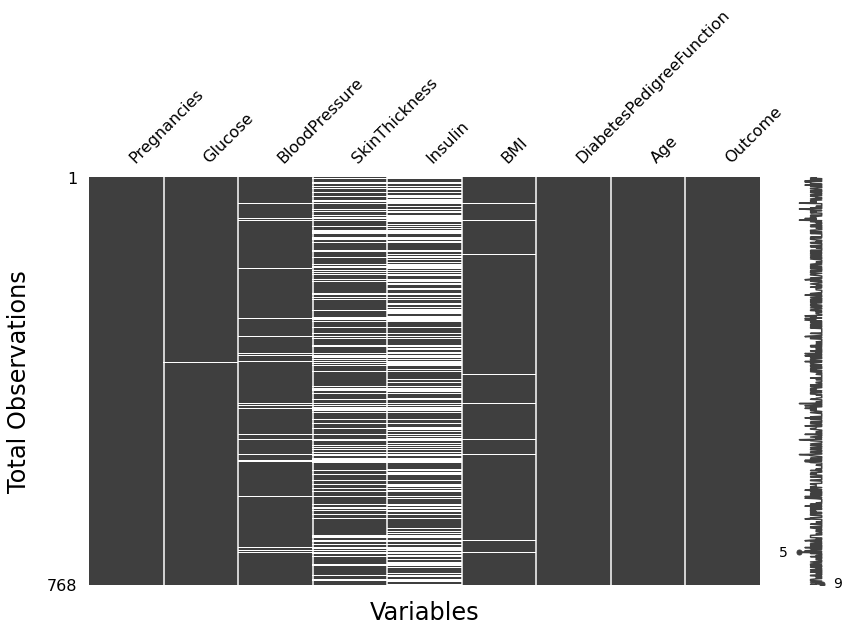

In [7]:
# Visualize the number of missing values as a matrix
fig = msno.matrix(diabetes, inline=False, figsize=(13.33,7.5))

# Add labels
plt.xlabel('Variables', size=24, labelpad=16)
plt.ylabel('Total Observations', size=24, labelpad=16)
plt.tick_params(axis='both', labelsize=16, length=8)

plt.show;

그럼 왜 굳이 Gibbs Sampler를 통해 NA imputation을 해야 할까?  
아래 heatmap을 보면 알 수 있듯이 variable 간에 correlation이 존재하기 때문에 각각 독립이라고 두고 sampling할 수 없다.
이번 주에 배웠듯이 Gibbs Sampler를 통해 Multivariate case를 쉽게 sampling할 수 있기 때문에 이런 Multivariate case에 적용할 수 있는 것이다.

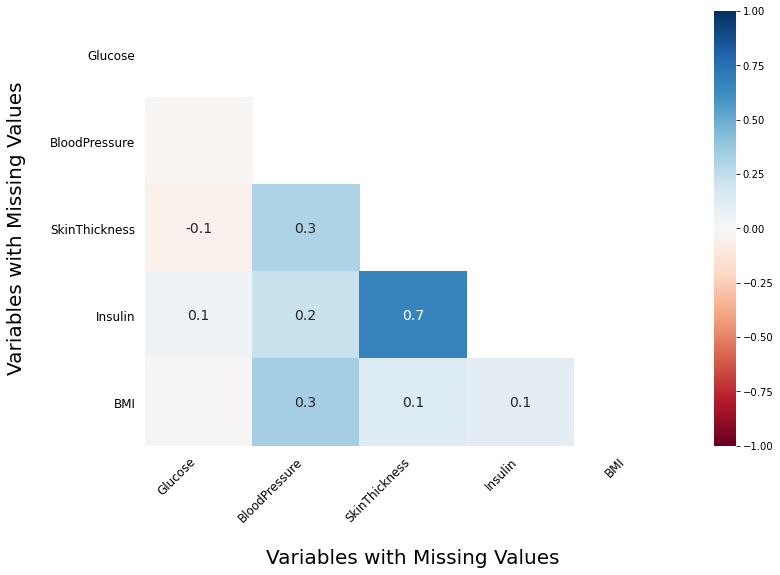

In [8]:
# Visualize the number of missing values as a heatmap
fig = msno.heatmap(diabetes, inline=False, figsize=(12,8))

# Add labels
plt.xlabel('Variables with Missing Values', size=20, labelpad=24)
plt.ylabel('Variables with Missing Values', size=20, labelpad=24)
plt.tick_params(axis='both', labelsize=12, length=6)

plt.show();

NaN이 그대로 남아있는 상태에서 pairplot을 그리면 다음과 같다. 대충 모든 변수가 정규분포를 따른다고 보고 MVN sampling을 적용해보자.  
그렇게 되면 각각의 row는 MVN dist를 따른다고 볼 수 있는 셈이다.  
  
correlation이 없는 변수도 있지만, 있는 변수들도 분명히 존재한다는 사실을 알 수 있다!  
(plot을 그릴 때 missing value가 있는 상태로 그리기 때문에 warning message가 출력된다. 무시 가능)

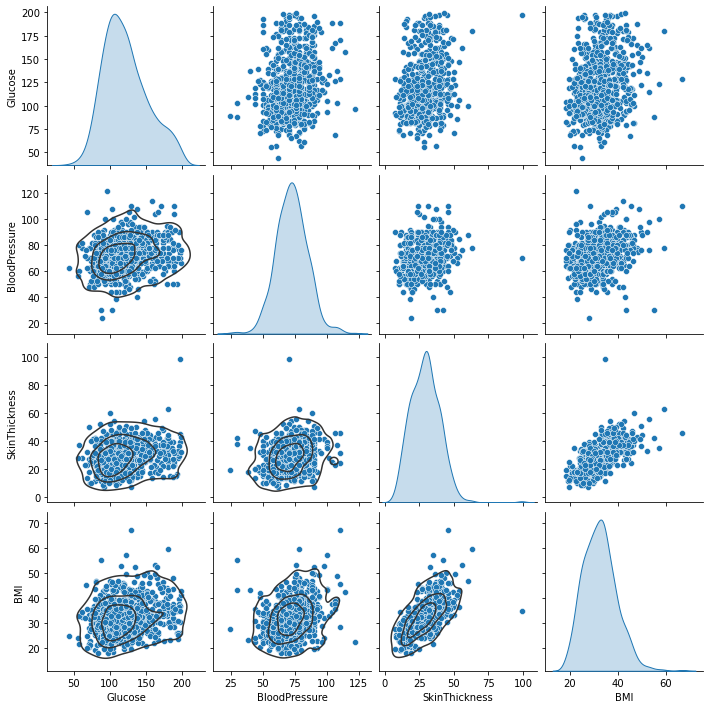

In [9]:
data = diabetes[['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']]

g = sns.pairplot(data, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

### Sampling Scheme  
  
sampling에 필요한 변수들, 함수들, prior distribution을 구성하는 parameter 기댓값 벡터 mu와 공분산 행렬 Lambda를 initialize하기  
1. $\mu | \Sigma \ \sim \ N(\mu_0, \Lambda_0)$  
2. $\Sigma | \mu \ \sim \ Wis^{-1}(\nu_0, S_0^{-1})$  
- $S_0 = (\nu_0 - d - 1)\Sigma_0$  

In [10]:
n = data.shape[0]       # data 수
p = data.shape[1]       # column 수

S = 100                 # number of iteration (몇 번 update 할건지)

# 자주 쓰는 함수
inv = np.linalg.inv     # 역행렬 구하기
t = np.transpose        # transpose

# priors
## prior for mu ~ N(  ,   )
# mean vector mu_0
mu0 = data.mean().to_numpy()    # column mean

# covariance matrix Lambda_0 : 공분산 행렬 만들기
sd0 = mu0 / 2                   # 왜 이렇게 initialize하는지 모르겠지만 암튼 prior란 원래 나름의 믿음에 따라 주는거니까..
# 아마 actual dataset의 dispersion을 고려하거나 해서 그런게 아닐까..?
L0 = np.ones((p,p))*0.1         # Lambda0 in prior    
di = np.diag_indices(p)         # diagonal index indicator
L0[di] = 1                      # 일단 분산을 1로 init
L0 = L0 * np.outer(sd0, sd0)    # off-diagonal terms

## prior for Sigma ~ Ing-Wishart(   ,   )
nu0 = p + 2                     # first param
S0 = (n-p-1) * L0   #@TODO

# misc
Sigma = S0                      # mu의 full conditional posterior를 초기화하는데 필요함
fill_data = data.copy()         # imputate할 dataset copy 만들기

O = data.isna().to_numpy()*1    # indicator variable (결측치 있으면 1, 결측치 없으면 0)

# Naive Imputation
for col in fill_data.columns:
    # 일단 mean imputation
    # 아마 계산 시 nan 있어서 생기는 error를 방지하기 위해서 나이브하게 뭐라도 채워놓고 simulation을 돌린것같음.
    fill_data[col].fillna(fill_data[col].mean(), inplace=True)

**Mean Imputation**  
Pros:  
- Prevent data loss which results in deletion of rows or columns  
- Works well with a small dataset and easy to implement.  
  
Cons:  
- Works only with numerical continuous variables.  
- Can cause data leakage  
- Does not factor the covariance between features.  
  
단순 평균으로만 채우는 건 간편하지만 위와 같은 단점이 있다. 가장 눈여겨 볼 것은 feature 간의 covariance structure를 잃어버리게 된다는 것인데, 무슨 말인지 아래 그림을 통해 확인할 수 있다. 결측치가 많았던 skin thickness의 density가 위의 original data와는 특히 달라졌다!


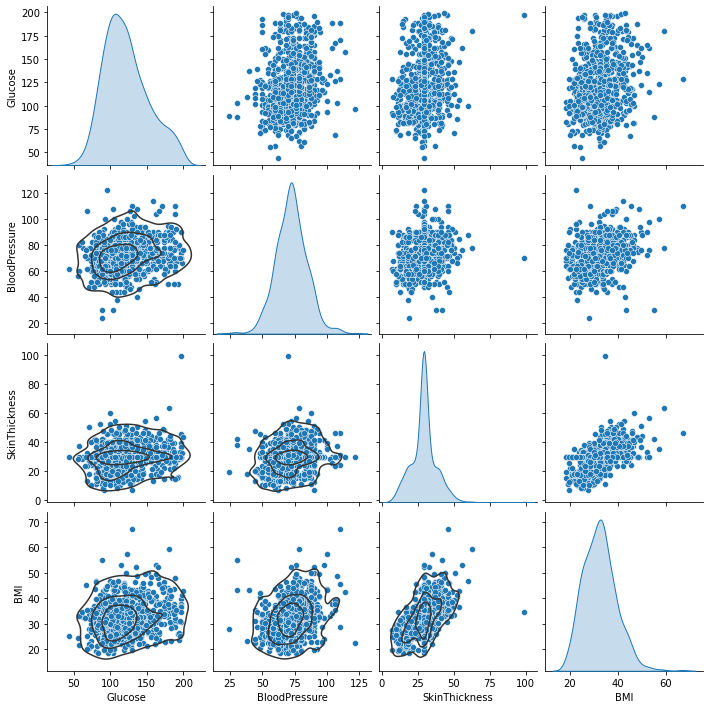

In [11]:
g_naive = sns.pairplot(fill_data, diag_kind="kde")
g_naive.map_lower(sns.kdeplot, levels=4, color=".2")

### Gibbs Sampler Execution  
  
그럼 이런 불상사가 발생하지 않게 feature 간의 covariance structure를 보존하면서 imputation을 해보자.  
  
1. $\mu | \Sigma, y \ \sim \ N(\mu_n, \Lambda_n)$  
- $\Lambda_n^{-1} = \Lambda_0^{-1} + n\Sigma^{-1}$  
- $\mu_n = \Lambda_n(\Lambda_0^{-1}\mu_0 + n\Sigma^{-1}\bar{y})$  
  

2. $\Sigma | \mu, y \ \sim \ Wis^{-1}(\nu_0+n, (S_0 + S_{\mu})^{-1})$  
- $S_{\mu} = \sum(y_i - \mu)(y_i - \mu)^T$
- $S_n = S_0 + S_{\mu}$
  
\- 그리고 결론적으로 각 row를 돌면서 imputation을 할텐데 각각의 행에서 우리가 관찰한 data는 결측치가 아닌 값이 된다.  
$y_{[b]} | y_{[a]}, \theta, \Sigma \ \sim \ MVN(\theta_{b|a}, \Sigma_{b|a})$ where  
- $\theta_{b|a} = \theta_{[b]} + \Sigma_{[b,a]}(\Sigma_{[a,a]})^{-1}(y_{[a]} - \theta_{[a]})$ (7.10)  
- $\Sigma_{b|a} = \Sigma_{[b,b]} - \Sigma_{[b,a]}(\Sigma_{[a,a]})^{-1}\Sigma_{[a,b]}$ (7.11)

In [12]:
for s in range(S):
    # update mu
    ybar = fill_data.mean().to_numpy()
    Ln = inv(inv(L0) + (inv(Sigma))*n)        # Lambda_n
    mun = np.matmul(Ln,
                    (np.matmul(inv(L0),mu0) + n*np.matmul(inv(Sigma),ybar)))       # mu_n
    ## sample mu from full conditional probability given Sigma & y ##
    Mu = stats.multivariate_normal.rvs(mun, Ln, 1)      

    # update Sigma
    S_mu = np.matmul(t(fill_data-Mu).to_numpy(),
                    (fill_data-Mu).to_numpy())
    Sn = S0 + S_mu
    ## sample Sigma from full conditional probability given mu & y ##
    Sigma = stats.invwishart.rvs(nu0+n, inv(Sn),1)

    # update missing data
    for i in range(n):

        # row별로 돌아가면서 1x4 array에 대해서 imputation
        # [T, F, F, T] 등의 형태로 indexing
        a = O[i,]==0        # i번째 row에 결측치 없는 위치
        b = O[i,]==1        # i번째 row에 결측치 있는 위치

        if sum(b)!=0:       # 결측치가 하나라도 있으면 imputation 진행! (결측치 하나도 없으면 sum(b)==0 loop 벗어남)
            # iSa, beta_j에 관한 설명은 좀 어려워서 스킵
            # 궁금하면 FCB p118 (7.10), (7.11) equation 설명 참고
            iSa = inv(Sigma[np.outer(a,a)].reshape(sum(a),sum(a)))
            beta_j = np.matmul(Sigma[np.outer(b,a)].reshape(sum(b),sum(a)), iSa)

            # Covariance Matrix for MVN distribution
            Sigma_j = Sigma[np.outer(b,b)].reshape(sum(b),sum(b)) - np.linalg.multi_dot([Sigma[np.outer(b,a)].reshape(sum(b),sum(a)), iSa, Sigma[np.outer(a,b)].reshape(sum(a),sum(b))])
            # Mean Vector for MVN distribution
            mu_j = Mu[b] + np.matmul(beta_j, t(fill_data.iloc[i, a])-Mu[a])

            # MVN 에서 결측치 있는 위치 (b)만 sampling한 값으로 채우기!
            fill_data.iloc[i,b] = stats.multivariate_normal.rvs(mu_j, Sigma_j, 1)

    if s%10==0:
        print(s,"/",S)

0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100


In [13]:
# 원래 결측치 있던 data
data

,Glucose,BloodPressure,SkinThickness,BMI
0,148.0,72.0,35.0,33.6
1,85.0,66.0,29.0,26.6
2,183.0,64.0,NaN,23.3
3,89.0,66.0,23.0,28.1
4,137.0,40.0,35.0,43.1
...,...,...,...,...
763,101.0,76.0,48.0,32.9
764,122.0,70.0,27.0,36.8
765,121.0,72.0,23.0,26.2
766,126.0,60.0,NaN,30.1


In [14]:
# Gibbs Sampler로 결측치를 채운 data
fill_data

,Glucose,BloodPressure,SkinThickness,BMI
0,148.0,72.0,35.000000,33.6
1,85.0,66.0,29.000000,26.6
2,183.0,64.0,-0.063925,23.3
3,89.0,66.0,23.000000,28.1
4,137.0,40.0,35.000000,43.1
...,...,...,...,...
763,101.0,76.0,48.000000,32.9
764,122.0,70.0,27.000000,36.8
765,121.0,72.0,23.000000,26.2
766,126.0,60.0,31.183301,30.1


잘 채워졌는지 봅시다!

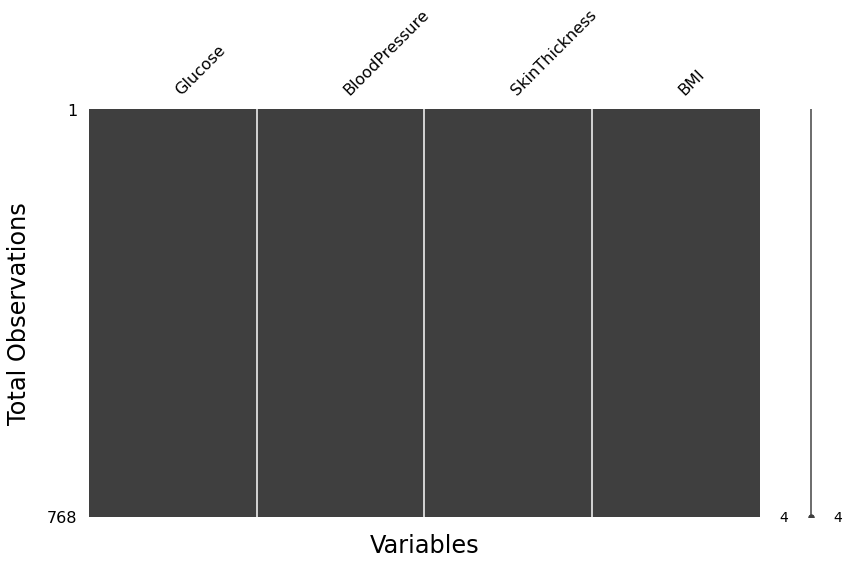

In [15]:
# Visualize the number of missing values as a matrix
fig = msno.matrix(fill_data, inline=False, figsize=(13.33,7.5))

# Add labels
plt.xlabel('Variables', size=24, labelpad=16)
plt.ylabel('Total Observations', size=24, labelpad=16)
plt.tick_params(axis='both', labelsize=16, length=8)

plt.show;

feature간의 covariance structure나 각 feature의 원래 분포도 원 데이터의 분포를 보존하고 있음을 볼 수 있다.

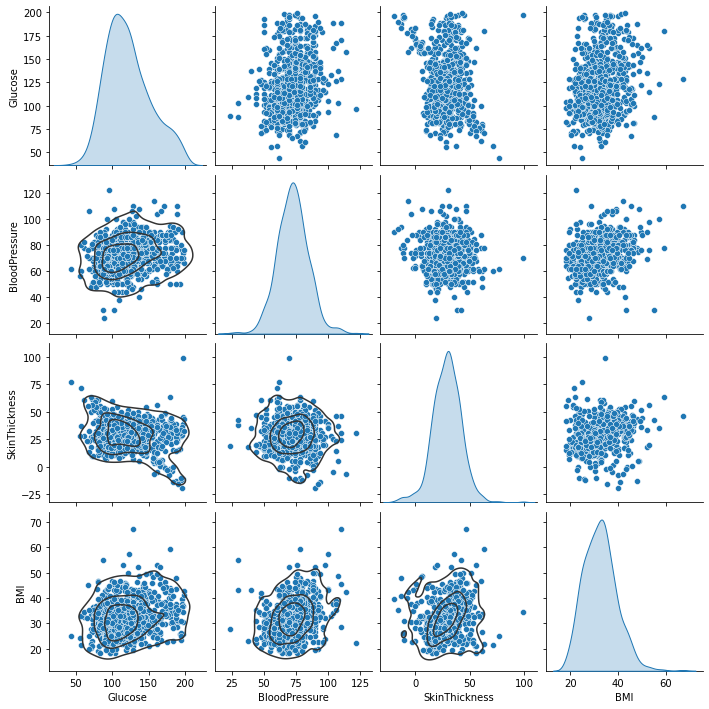

In [16]:
g_filled = sns.pairplot(fill_data, diag_kind="kde")
g_filled.map_lower(sns.kdeplot, levels=4, color=".2")